In [1]:
import configure_v7 as config
import utils_v7 as utils
import pickle
import scipy.io
import glob
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch
def data_formulate(data, adj_name = 'State_adj',test_size = 0.5, shuffle=False):
    # State_adj
    x_data = np.array(data[
        'X'],dtype=np.float16)  # shape (26,550,1289) (Task ID (Spatial location), Sample (Temporal-Days), Features(TF-IDF)) # Civil Unrest Data
    y_data = np.array(data['Y5'],dtype=np.float16)  # shape (26, 550) # argentina: Y5
    adj_data = np.array(data[adj_name],dtype=np.float16)  # shape (26, 26)

    y_data_3d = np.expand_dims(y_data, axis=2)
    data_concat = np.swapaxes(np.concatenate((x_data, y_data_3d), axis=2), 0, 1)
    data_train, data_test = train_test_split(data_concat, test_size=test_size, random_state=42, shuffle=shuffle)  # Split the set
    with torch.no_grad():
        X_train = torch.swapaxes(torch.FloatTensor(data_train[:, :, 0:-1]), 0, 1)  # Shape([26, 275, 1289])
        Y_train = torch.swapaxes(torch.FloatTensor(data_train[:, :, -1]), 0, 1)
        X_test = torch.swapaxes(torch.FloatTensor(data_test[:, :, 0:-1]), 0, 1)
        Y_test = torch.swapaxes(torch.FloatTensor(data_test[:, :, -1]), 0, 1)
    values = Y_train.unique()
    if values[0] == 0:  # This logic was added for fixing the label issue.
        Y_train += 1
        Y_test += 1
        print('Label increased by 1 to fix the label issue')
    return [X_train, Y_train, X_test, Y_test, adj_data]
def prediction_from_obj(model_location):
    model_load_file = open(model_location, 'rb')
    MITOR_V2_trained = pickle.load(model_load_file)
    MITOR_V2_trained.W=-MITOR_V2_trained.W
    [mze, mae, Y_pred] = MITOR_V2_trained.predict(X_test, Y_test, True)
    return [mze, mae, Y_pred]

In [3]:
# load data
data = scipy.io.loadmat(config.data_location) # data format: dict
[X_train, Y_train, X_test, Y_test, adj_data] = data_formulate(data)

C:\ProgramData\Anaconda3\envs\Incomplete_label_multi_task\lib\site-packages\scipy\io\matlab\mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [4]:
# Creating the dictionary
folder_location = '../saved_model/Flu_11_12_models/'
details_mze = {
    'Model Name' : []
}
details_mae = {
    'Model Name' : []
}
for i in range(0, 5001, 250):
    details_mze[i]=[]
    details_mae[i]=[]
for model_location in glob.glob('../saved_model/Flu_11_12_models/*.obj', recursive=True):
    date = model_location.split('_MITOR_V2_mlp')[0].split('\\')[1]
    if date not in details_mze['Model Name']:
        details_mze['Model Name'].append(date)
        details_mae['Model Name'].append(date)

In [5]:
# Populate the dictionary
for i, v in enumerate(details_mze['Model Name']):
    for j in range(0,5001,250):
        if j==0:
            model_location = folder_location+v+'_MITOR_V2_mlp.obj'
        else:
            model_location = folder_location+v+'_MITOR_V2_mlp'+str(j)+'.obj'
        try:
            [mze, mae, Y_pred] = prediction_from_obj(model_location)
            details_mze[j].append(mze)
            details_mae[j].append(mae)
        except:
#             print(model_location)
            details_mze[j].append(0)
            details_mae[j].append(0)

In [6]:
# import pandas library
import pandas as pd  
# creating a Dataframe object 
df_mze = pd.DataFrame(details_mze)
df_mae = pd.DataFrame(details_mae)

In [10]:
df_mze.to_csv(folder_location+'mze_flu_11_12.csv')
df_mae.to_csv(folder_location+'mae_flu_11_12.csv')

In [68]:
df_mze_transposed = df_mze.T
df_mze_transposed.columns = df_mze_transposed.iloc[0]
df_mze_transposed = df_mze_transposed.drop(labels='Model Name', axis=0)
df_mze_transposed[list(df_mze_transposed.columns)]= df_mze_transposed[list(df_mze_transposed.columns)].astype(float)

In [69]:
df_mae_transposed = df_mae.T
df_mae_transposed.columns = df_mae_transposed.iloc[0]
df_mae_transposed = df_mae_transposed.drop(labels='Model Name', axis=0)
df_mae_transposed[list(df_mae_transposed.columns)]= df_mae_transposed[list(df_mae_transposed.columns)].astype(float)

In [72]:
min_iter_dict = {'Model Name': details_mze['Model Name'],
                'min_mze_val':list(df_mze_transposed[df_mze_transposed > 0].min(axis=0)),
                'min_mze_iter':list(df_mze_transposed[df_mze_transposed > 0].idxmin()),
                'min_mae_val':list(df_mae_transposed[df_mae_transposed > 0].min(axis=0)),
                'min_mae_iter':list(df_mae_transposed[df_mae_transposed > 0].idxmin())}
min_iter_df = pd.DataFrame(min_iter_dict)
min_iter_df = min_iter_df.dropna()
min_iter_df.to_csv(folder_location+'min_flu_11_12.csv')

In [ ]:
import matplotlib.pyplot as mp
df_mze_transposed.plot(y=list(df_mze_transposed.columns), use_index=True)

In [73]:
min(list(df_mze_transposed[df_mze_transposed > 0].min(axis=0)))

0.10827119648456573

In [87]:
summary_df = pd.read_csv(folder_location+'flu_experiments_summary.csv', index_col=0)  

In [88]:
summary_df.head()

,Model Name,min_mze_val,min_mze_iter,min_mae_val,min_mae_iter,alpha,beta,rho,lr_ADMM,lr_MLP,hidden_dim,activation,optimizer,weight_decay,tol_L,tol_r,tol_s,tol_r_s,ADI,Max_iter
Index,,,,,,,,,,,,,,,,,,,,
0,03_07_2022_23_31_45,0.120339,5000,0.217769,5000,0.0,0.001,10,0.8,0.000000,200,relu,off,0,0.001,1.000000e-10,1.000000e-10,10,5000,1000
1,04_07_2022_09_46_34,0.137951,1250,0.235479,1250,0.0,0.001,10,0.8,0.000001,200,selu,sgd,0,0.001,1.000000e-10,1.000000e-10,10,5000,1000
2,04_07_2022_10_29_27,0.109939,4750,0.182545,4750,0.0,0.001,10,0.8,0.000001,200,relu,sgd,0,0.001,1.000000e-10,1.000000e-10,10,5000,1000
3,04_07_2022_10_38_33,0.108271,500,0.180141,500,0.0,0.001,10,0.8,0.000100,200,relu,sgd,0,0.001,1.000000e-10,1.000000e-10,10,5000,1000
4,04_07_2022_10_38_42,0.131427,250,0.242494,250,0.0,0.001,10,0.8,0.010000,200,relu,sgd,0,0.001,1.000000e-10,1.000000e-10,10,5000,1000


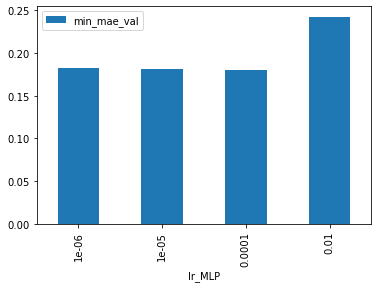

In [112]:
lr_MLP_df = summary_df.groupby('activation').get_group('relu').groupby('optimizer').get_group('sgd').groupby('lr_MLP')
# lr_MLP_df['min_mze_val'].min().plot(legend=True,  logx=False, kind = 'bar') 
lr_MLP_df['min_mae_val'].min().plot(legend=True,  logx=False, kind = 'bar') 

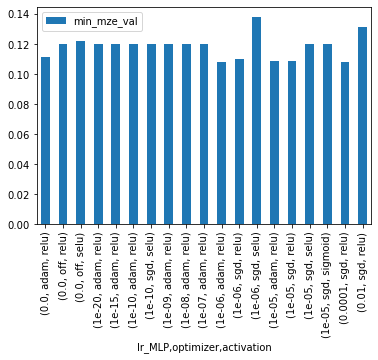

In [124]:
summary_df.groupby(['lr_MLP', 'optimizer','activation'])['min_mze_val'].min().plot(legend=True,  logx=False, kind = 'bar') 
summary_df.groupby(['lr_MLP', 'optimizer','activation'])['min_mae_val'].min().plot(legend=True,  logx=False, kind = 'bar') 

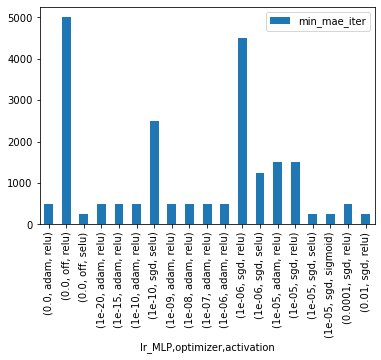

In [126]:
# summary_df.groupby(['lr_MLP', 'optimizer','activation'])['min_mze_iter'].min().plot(legend=True,  logx=False, kind = 'bar') 
summary_df.groupby(['lr_MLP', 'optimizer','activation'])['min_mae_iter'].min().plot(legend=True,  logx=False, kind = 'bar') 
